In [ ]:
#| default_exp handlers.geotraces

# Geotraces
> Data pipeline (handler) to convert BODC Geotraces seawater dataset

Ref: 
    
    - https://www.geotraces.org/geotraces-intermediate-data-product-2021/
    - zotero MARIS geotraces entry (2018 only?): https://www.zotero.org/groups/2432820/maris/items/97UIMEXN


BODC bottle id

temperature, oxygen, station (optional), samplabcode 

List of all accepted maris master db cols:
- sample_id
- sampquality
- ref_id
- osamcod
- samplabcode
- samptype_id
- lab_id
- station
- aqcs
- sedtrap
- aqcsyear
- aqcsmonth
- totdepth
- sampdepth
- volume
- salinity
- temperatur
- filtered
- acid
- oxygen
- samparea
- sliceup
- slicedown
- sieved
- organic
- oxic
- drytemp
- drywt
- wetwt
- percentwt
- filtpore
- sampnote
- begperiod
- endperiod
- sedtype_id
- drymet_id
- species_id
- bodypar_id
- sampmet_id
- prepmet_id
- gfe
- Commonname
- TaxonRepName
- SedRepName
- shiftedcoordinates
- shiftedLong
- shiftedLat
- longitude
- latitude

TODO & QUESTIONS:

- salinity, temperature, oxygen, station(?), samplabcode (BODC bottle ID?)
- How to handle this unit? U_236_238_T_RATIO_BOTTLE [per 10^12]

## Packages import

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#| export
from tqdm import tqdm
from pathlib import Path
import fastcore.all as fc
import pandas as pd
import numpy as np
import re

from marisco.callbacks import (
    Callback, 
    Transformer, 
    SanitizeLonLatCB, 
    EncodeTimeCB,
    ReshapeLongToWide
)

from marisco.metadata import (
    GlobAttrsFeeder, 
    BboxCB,
    DepthRangeCB, 
    TimeRangeCB,
    ZoteroCB,
    KeyValuePairCB
)

from marisco.configs import (
    lut_path, 
    cdl_cfg, 
    cfg, 
    nc_tpl_path, 
    Enums
)

from marisco.serializers import NetCDFEncoder

In [ ]:
pd.set_option('display.max_rows', 200)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

So again, the 1 million question is still there: what constitutes a single sample in the context of Geotraces?

## Input and output file names

In [ ]:
# | exports
fname_in = '../../_data/geotraces/GEOTRACES_IDP2021_v2/seawater/ascii/GEOTRACES_IDP2021_Seawater_Discrete_Sample_Data_v2.csv'
fname_out = '../../_data/output/190-geotraces-2021.nc'

## Load data

In [ ]:
#| exports
load_data = lambda fname: pd.read_csv(fname_in)

In [ ]:
#| eval: false
df = load_data(fname_in)
print(f'df shape: {df.shape}')
df.head()

df shape: (105417, 1188)


,Cruise,Station:METAVAR:INDEXED_TEXT,Type,yyyy-mm-ddThh:mm:ss.sss,Longitude [degrees_east],Latitude [degrees_north],Bot. Depth [m],Operator's Cruise Name:METAVAR:INDEXED_TEXT,Ship Name:METAVAR:INDEXED_TEXT,Period:METAVAR:INDEXED_TEXT,...,QV:SEADATANET.581,Co_CELL_CONC_BOTTLE [amol/cell],QV:SEADATANET.582,Ni_CELL_CONC_BOTTLE [amol/cell],QV:SEADATANET.583,Cu_CELL_CONC_BOTTLE [amol/cell],QV:SEADATANET.584,Zn_CELL_CONC_BOTTLE [amol/cell],QV:SEADATANET.585,QV:ODV:SAMPLE
0,GA01,0,B,2014-05-17T22:29:00,349.29999,38.4329,4854.0,GEOVIDE,Pourquoi pas?,15/05/2014 - 30/06/2014,...,9,NaN,9,NaN,9,NaN,9,NaN,9,1
1,GA01,0,B,2014-05-17T22:29:00,349.29999,38.4329,4854.0,GEOVIDE,Pourquoi pas?,15/05/2014 - 30/06/2014,...,9,NaN,9,NaN,9,NaN,9,NaN,9,1
2,GA01,0,B,2014-05-17T22:29:00,349.29999,38.4329,4854.0,GEOVIDE,Pourquoi pas?,15/05/2014 - 30/06/2014,...,9,NaN,9,NaN,9,NaN,9,NaN,9,1
3,GA01,0,B,2014-05-17T22:29:00,349.29999,38.4329,4854.0,GEOVIDE,Pourquoi pas?,15/05/2014 - 30/06/2014,...,9,NaN,9,NaN,9,NaN,9,NaN,9,1
4,GA01,0,B,2014-05-17T22:29:00,349.29999,38.4329,4854.0,GEOVIDE,Pourquoi pas?,15/05/2014 - 30/06/2014,...,9,NaN,9,NaN,9,NaN,9,NaN,9,1


In [ ]:
df.columns[:20]

Index(['Cruise', 'Station:METAVAR:INDEXED_TEXT', 'Type',
       'yyyy-mm-ddThh:mm:ss.sss', 'Longitude [degrees_east]',
       'Latitude [degrees_north]', 'Bot. Depth [m]',
       'Operator's Cruise Name:METAVAR:INDEXED_TEXT',
       'Ship Name:METAVAR:INDEXED_TEXT', 'Period:METAVAR:INDEXED_TEXT',
       'Chief Scientist:METAVAR:INDEXED_TEXT',
       'GEOTRACES Scientist:METAVAR:INDEXED_TEXT',
       'Cruise Aliases:METAVAR:INDEXED_TEXT',
       'Cruise Information Link:METAVAR:INDEXED_TEXT',
       'BODC Cruise Number:METAVAR:INTEGER', 'CTDPRS_T_VALUE_SENSOR [dbar]',
       'QV:SEADATANET', 'DEPTH [m]', 'QV:SEADATANET.1',
       'Rosette Bottle Number:INTEGER'],
      dtype='object')

In [ ]:
unique_key = [
    'yyyy-mm-ddThh:mm:ss.sss', 
    'Longitude [degrees_east]', 
    'Latitude [degrees_north]', 
    'DEPTH [m]', 
    'BODC Bottle Number:INTEGER'
]

print(f'df duplicated keys: ', df[unique_key].duplicated().sum())   

df duplicated keys:  423


In [ ]:
df[df[unique_key].duplicated(keep=False)].sort_values(by=unique_key)

,Cruise,Station:METAVAR:INDEXED_TEXT,Type,yyyy-mm-ddThh:mm:ss.sss,Longitude [degrees_east],Latitude [degrees_north],Bot. Depth [m],Operator's Cruise Name:METAVAR:INDEXED_TEXT,Ship Name:METAVAR:INDEXED_TEXT,Period:METAVAR:INDEXED_TEXT,...,QV:SEADATANET.581,Co_CELL_CONC_BOTTLE [amol/cell],QV:SEADATANET.582,Ni_CELL_CONC_BOTTLE [amol/cell],QV:SEADATANET.583,Cu_CELL_CONC_BOTTLE [amol/cell],QV:SEADATANET.584,Zn_CELL_CONC_BOTTLE [amol/cell],QV:SEADATANET.585,QV:ODV:SAMPLE
9835,GA03,Station 5,B,2010-10-21T23:39:56,338.09882,31.0028,5011.0,KN199,Knorr,15/10/2010 - 04/11/2010,...,9,NaN,9,3.43,1,16.00,1,2.710000,1,1
9836,GA03,Station 5,B,2010-10-21T23:39:56,338.09882,31.0028,5011.0,KN199,Knorr,15/10/2010 - 04/11/2010,...,9,NaN,9,0.14,1,0.23,1,0.280000,1,1
9837,GA03,Station 5,B,2010-10-21T23:39:56,338.09882,31.0028,5011.0,KN199,Knorr,15/10/2010 - 04/11/2010,...,1,0.23,1,NaN,9,NaN,9,1.460000,1,1
9838,GA03,Station 5,B,2010-10-21T23:39:56,338.09882,31.0028,5011.0,KN199,Knorr,15/10/2010 - 04/11/2010,...,9,NaN,9,32.50,1,209.00,1,12.000000,1,1
9839,GA03,Station 5,B,2010-10-21T23:39:56,338.09882,31.0028,5011.0,KN199,Knorr,15/10/2010 - 04/11/2010,...,1,0.24,1,NaN,9,NaN,9,1.900000,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92211,GP16,36,B,2013-12-17T04:09:34,207.99300,-10.5019,5162.0,TN303,Thomas G. Thompson,25/10/2013 - 20/12/2013,...,1,NaN,9,3.72,1,NaN,9,6.950000,1,1
92212,GP16,36,B,2013-12-17T04:09:34,207.99300,-10.5019,5162.0,TN303,Thomas G. Thompson,25/10/2013 - 20/12/2013,...,1,1.06,1,1.68,1,NaN,9,11.300000,1,1
92213,GP16,36,B,2013-12-17T04:09:34,207.99300,-10.5019,5162.0,TN303,Thomas G. Thompson,25/10/2013 - 20/12/2013,...,1,NaN,9,14.70,1,NaN,9,16.299999,1,1
92214,GP16,36,B,2013-12-17T04:09:34,207.99300,-10.5019,5162.0,TN303,Thomas G. Thompson,25/10/2013 - 20/12/2013,...,1,NaN,9,2.05,1,NaN,9,12.800000,1,1


In [ ]:
for col in df.columns:
    print(col)
    print(df[col].unique()[:5])
    print()

Cruise
['GA01' 'GA02' 'GA03' 'GA04N' 'GA04S']

Station:METAVAR:INDEXED_TEXT
[0 1 2 3 4]

Type
['B']

yyyy-mm-ddThh:mm:ss.sss
['2014-05-17T22:29:00' '2014-05-19T18:19:18' '2014-05-20T23:04:59'
 '2014-05-21T04:20:56' '2014-05-21T16:32:53']

Longitude [degrees_east]
[349.29999 349.96399 350.54053 350.35678 350.23337]

Latitude [degrees_north]
[38.4329 40.3333 40.3331 40.3329 40.333 ]

Bot. Depth [m]
[4854. 3578.  153.  439.  804.]

Operator's Cruise Name:METAVAR:INDEXED_TEXT
['GEOVIDE' 'JC057' 'PE319' 'PE321' 'PE358']

Ship Name:METAVAR:INDEXED_TEXT
['Pourquoi pas?' 'RRS James Cook' 'Pelagia' 'Knorr' 'Angeles Alvarino']

Period:METAVAR:INDEXED_TEXT
['15/05/2014 - 30/06/2014' '02/03/2011 - 06/04/2011'
 '28/04/2010 - 26/05/2010' '11/06/2010 - 08/07/2010'
 '29/07/2012 - 19/08/2012']

Chief Scientist:METAVAR:INDEXED_TEXT
['Sarthou Geraldine' 'Rijkenberg Micha' 'Gerringa Loes' 'Jenkins William'
 'Boyle Edward']

GEOTRACES Scientist:METAVAR:INDEXED_TEXT
['Sarthou Geraldine' 'de Baar Hein' 'Boyl

In [ ]:
# 'BODC Bottle Number:INTEGER'

cols_unique = [
    'yyyy-mm-ddThh:mm:ss.sss', 
    'Longitude [degrees_east]',
    'Latitude [degrees_north]',
    'DEPTH [m]',
    'BODC Bottle Number:INTEGER'
    # 'Rosette Bottle Number:INTEGER',
]

df[cols_unique].head()

,yyyy-mm-ddThh:mm:ss.sss,Longitude [degrees_east],Latitude [degrees_north],DEPTH [m],BODC Bottle Number:INTEGER
0,2014-05-17T22:29:00,349.29999,38.4329,2957.1,1214048
1,2014-05-17T22:29:00,349.29999,38.4329,2957.2,1214039
2,2014-05-17T22:29:00,349.29999,38.4329,2957.2,1214027
3,2014-05-17T22:29:00,349.29999,38.4329,2957.2,1214018
4,2014-05-17T22:29:00,349.29999,38.4329,2957.2,1214036


In [ ]:
df[df[cols_unique].duplicated()]

,Cruise,Station:METAVAR:INDEXED_TEXT,Type,yyyy-mm-ddThh:mm:ss.sss,Longitude [degrees_east],Latitude [degrees_north],Bot. Depth [m],Operator's Cruise Name:METAVAR:INDEXED_TEXT,Ship Name:METAVAR:INDEXED_TEXT,Period:METAVAR:INDEXED_TEXT,...,QV:SEADATANET.581,Co_CELL_CONC_BOTTLE [amol/cell],QV:SEADATANET.582,Ni_CELL_CONC_BOTTLE [amol/cell],QV:SEADATANET.583,Cu_CELL_CONC_BOTTLE [amol/cell],QV:SEADATANET.584,Zn_CELL_CONC_BOTTLE [amol/cell],QV:SEADATANET.585,QV:ODV:SAMPLE
9571,GA03,Station 12,B,2010-11-02T17:03:15,335.5022,17.4021,3548.0,KN199,Knorr,15/10/2010 - 04/11/2010,...,9,NaN,9,0.07,1,1.48,1,21.700001,1,1
9573,GA03,Station 12,B,2010-11-02T17:03:15,335.5022,17.4021,3548.0,KN199,Knorr,15/10/2010 - 04/11/2010,...,1,0.10,1,NaN,9,NaN,9,1.040000,1,1
9574,GA03,Station 12,B,2010-11-02T17:03:15,335.5022,17.4021,3548.0,KN199,Knorr,15/10/2010 - 04/11/2010,...,1,NaN,9,NaN,9,NaN,9,22.100000,1,1
9576,GA03,Station 12,B,2010-11-02T17:03:15,335.5022,17.4021,3548.0,KN199,Knorr,15/10/2010 - 04/11/2010,...,1,0.10,1,NaN,9,NaN,9,2.500000,1,1
9577,GA03,Station 12,B,2010-11-02T17:03:15,335.5022,17.4021,3548.0,KN199,Knorr,15/10/2010 - 04/11/2010,...,1,0.07,1,NaN,9,NaN,9,0.560000,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92211,GP16,36,B,2013-12-17T04:09:34,207.9930,-10.5019,5162.0,TN303,Thomas G. Thompson,25/10/2013 - 20/12/2013,...,1,NaN,9,3.72,1,NaN,9,6.950000,1,1
92212,GP16,36,B,2013-12-17T04:09:34,207.9930,-10.5019,5162.0,TN303,Thomas G. Thompson,25/10/2013 - 20/12/2013,...,1,1.06,1,1.68,1,NaN,9,11.300000,1,1
92213,GP16,36,B,2013-12-17T04:09:34,207.9930,-10.5019,5162.0,TN303,Thomas G. Thompson,25/10/2013 - 20/12/2013,...,1,NaN,9,14.70,1,NaN,9,16.299999,1,1
92214,GP16,36,B,2013-12-17T04:09:34,207.9930,-10.5019,5162.0,TN303,Thomas G. Thompson,25/10/2013 - 20/12/2013,...,1,NaN,9,2.05,1,NaN,9,12.800000,1,1


In [ ]:
df['GEOTRACES Sample ID:INDEXED_TEXT'].unique()

array([nan, 24.0, 23.0, ..., 3056.0, 3057.0, 0], dtype=object)

In [ ]:
df[df['GEOTRACES Sample ID:INDEXED_TEXT'] == 24.0]

,Cruise,Station:METAVAR:INDEXED_TEXT,Type,yyyy-mm-ddThh:mm:ss.sss,Longitude [degrees_east],Latitude [degrees_north],Bot. Depth [m],Operator's Cruise Name:METAVAR:INDEXED_TEXT,Ship Name:METAVAR:INDEXED_TEXT,Period:METAVAR:INDEXED_TEXT,...,QV:SEADATANET.581,Co_CELL_CONC_BOTTLE [amol/cell],QV:SEADATANET.582,Ni_CELL_CONC_BOTTLE [amol/cell],QV:SEADATANET.583,Cu_CELL_CONC_BOTTLE [amol/cell],QV:SEADATANET.584,Zn_CELL_CONC_BOTTLE [amol/cell],QV:SEADATANET.585,QV:ODV:SAMPLE
5372,GA02,001,B,2011-03-05T20:45:44,307.31189,-49.5472,2322.0,JC057,RRS James Cook,02/03/2011 - 06/04/2011,...,9,NaN,9,NaN,9,NaN,9,NaN,9,1
5373,GA02,001,B,2011-03-05T20:45:44,307.31189,-49.5472,2322.0,JC057,RRS James Cook,02/03/2011 - 06/04/2011,...,9,NaN,9,NaN,9,NaN,9,NaN,9,1
5443,GA02,001,B,2012-07-31T11:17:29,325.02731,60.6544,2971.0,PE358,Pelagia,29/07/2012 - 19/08/2012,...,9,NaN,9,NaN,9,NaN,9,NaN,9,1
5446,GA02,001,B,2010-04-29T14:37:28,349.01709,60.4053,756.0,PE319,Pelagia,28/04/2010 - 26/05/2010,...,9,NaN,9,NaN,9,NaN,9,NaN,9,1
5491,GA02,002,B,2012-08-02T00:54:40,320.49039,59.2002,3031.0,PE358,Pelagia,29/07/2012 - 19/08/2012,...,9,NaN,9,NaN,9,NaN,9,NaN,9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100417,GPpr11,(8),B,2016-04-02T04:53:15,147.07700,-50.3882,4416.0,IN2016_V02,Investigator,15/03/2016 - 13/04/2016,...,9,NaN,9,NaN,9,NaN,9,NaN,9,1
100418,GPpr11,(8),B,2016-04-02T04:53:15,147.07700,-50.3882,4416.0,IN2016_V02,Investigator,15/03/2016 - 13/04/2016,...,9,NaN,9,NaN,9,NaN,9,NaN,9,1
100419,GPpr11,(8),B,2016-04-02T04:53:15,147.07700,-50.3882,4416.0,IN2016_V02,Investigator,15/03/2016 - 13/04/2016,...,9,NaN,9,NaN,9,NaN,9,NaN,9,1
100421,GPpr11,(8),B,2016-04-02T04:53:15,147.07700,-50.3882,4416.0,IN2016_V02,Investigator,15/03/2016 - 13/04/2016,...,9,NaN,9,NaN,9,NaN,9,NaN,9,1


In [ ]:
df['Rosette Bottle Number:INTEGER'].unique()

array([19., 16., 12.,  9., 15., 22., 13.,  2., 23.,  3., 18., 14., 21.,
       10., 17.,  7.,  4.,  6.,  1.,  8., 24.,  5., 11., 20., nan, 25.,
       26., 36., 35., 34., 32., 33., 31., 28., 27., 30., 29.])

In [ ]:
for col in df.columns:
    print(col)
    print(df[col].unique()[:5])
    print()

Cruise
['GA01' 'GA02' 'GA03' 'GA04N' 'GA04S']

Station:METAVAR:INDEXED_TEXT
[0 1 2 3 4]

Type
['B']

yyyy-mm-ddThh:mm:ss.sss
['2014-05-17T22:29:00' '2014-05-19T18:19:18' '2014-05-20T23:04:59'
 '2014-05-21T04:20:56' '2014-05-21T16:32:53']

Longitude [degrees_east]
[349.29999 349.96399 350.54053 350.35678 350.23337]

Latitude [degrees_north]
[38.4329 40.3333 40.3331 40.3329 40.333 ]

Bot. Depth [m]
[4854. 3578.  153.  439.  804.]

Operator's Cruise Name:METAVAR:INDEXED_TEXT
['GEOVIDE' 'JC057' 'PE319' 'PE321' 'PE358']

Ship Name:METAVAR:INDEXED_TEXT
['Pourquoi pas?' 'RRS James Cook' 'Pelagia' 'Knorr' 'Angeles Alvarino']

Period:METAVAR:INDEXED_TEXT
['15/05/2014 - 30/06/2014' '02/03/2011 - 06/04/2011'
 '28/04/2010 - 26/05/2010' '11/06/2010 - 08/07/2010'
 '29/07/2012 - 19/08/2012']

Chief Scientist:METAVAR:INDEXED_TEXT
['Sarthou Geraldine' 'Rijkenberg Micha' 'Gerringa Loes' 'Jenkins William'
 'Boyle Edward']

GEOTRACES Scientist:METAVAR:INDEXED_TEXT
['Sarthou Geraldine' 'de Baar Hein' 'Boyl

In [ ]:
df["Ship Name:METAVAR:INDEXED_TEXT"].unique()

array(['Pourquoi pas?', 'RRS James Cook', 'Pelagia', 'Knorr',
       'Angeles Alvarino', 'RRS Discovery', 'Meteor', 'FS Meteor',
       'James Cook', 'Atlantic Explorer', 'Pelican', 'Point Sur',
       'Sagar Kanya', 'Hakuho Maru', 'Tangaroa', 'Aurora Australis',
       'Marion Dufresne', 'FS Polarstern', 'Jakov Smirnitskiy',
       'Investigator', 'S. A. Agulhas II', 'Sam Rothberg', 'Healy',
       'Amundsen', 'Polarstern', "L'Atalante", 'RV Southern Surveyor',
       'Roger Revelle', 'Thomas G. Thompson', 'Sonne', 'Kilo Moana',
       'John P. Tully', 'Nathaniel B. Palmer', 'Akademik Tryoshnikov'],
      dtype=object)

In [ ]:
#| eval: false
def find_print_col(s, cols, lower=True):
    cols = cols if not lower else [col.lower() for col in cols]
    for col in cols:
        if s in col: print(col)

find_print_col('sal', df.columns)
find_print_col('tmp', df.columns)
find_print_col('oxy', df.columns)
find_print_col('U_236_238', df.columns, lower=False)

ctdsal_d_conc_sensor [pss-78]
salinity_d_conc_bottle
salinity_d_conc_pump
salinity_d_conc_fish
salinity_d_conc_uway
salinity_d_conc_boat_pump
ctdtmp_t_value_sensor [deg c]
oxygen_d_conc_bottle [umol/kg]
ctdoxy_d_conc_sensor [umol/kg]
U_236_238_T_RATIO_BOTTLE [per 10^12]


## Data transformation pipeline

### Select columns of interest

In [ ]:
#| hide
# U_236_238
# Done: Th_232, I_129, Ac_227

In [ ]:
#| exports
common_coi = ['yyyy-mm-ddThh:mm:ss.sss', 'Longitude [degrees_east]',
              'Latitude [degrees_north]', 'Bot. Depth [m]', 'DEPTH [m]', 'BODC Bottle Number:INTEGER']

nuclides_pattern = ['^TRITI', '^Th_228', '^Th_23[024]', '^Pa_231', 
                    '^U_236_[DT]', '^Be_', '^Cs_137', '^Pb_210', '^Po_210',
                    '^Ra_22[3468]', 'Np_237', '^Pu_239_[D]', '^Pu_240', '^Pu_239_Pu_240',
                    '^I_129', '^Ac_227']  

class SelectColsOfInterestCB(Callback):
    "Select columns of interest."
    def __init__(self, common_coi, nuclides_pattern): fc.store_attr()
    def __call__(self, tfm):
        nuc_of_interest = [c for c in tfm.df.columns if 
                           any(re.match(pattern, c) for pattern in self.nuclides_pattern)]

        tfm.df = tfm.df[self.common_coi + nuc_of_interest]

In [ ]:
#| eval: false
tfm = Transformer(df, cbs=[
    SelectColsOfInterestCB(common_coi, nuclides_pattern)
])

In [ ]:
#| eval: false
df_test = tfm()
print(f'df_test shape: {df_test.shape}')
df_test.head()

df_test shape: (105417, 86)


,yyyy-mm-ddThh:mm:ss.sss,Longitude [degrees_east],Latitude [degrees_north],Bot. Depth [m],DEPTH [m],BODC Bottle Number:INTEGER,TRITIUM_D_CONC_BOTTLE [TU],Cs_137_D_CONC_BOTTLE [uBq/kg],I_129_D_CONC_BOTTLE [atoms/kg],Np_237_D_CONC_BOTTLE [uBq/kg],...,Th_230_TP_CONC_PUMP [uBq/kg],Th_230_SPT_CONC_PUMP [uBq/kg],Th_230_LPT_CONC_PUMP [uBq/kg],Th_232_TP_CONC_PUMP [pmol/kg],Th_232_SPT_CONC_PUMP [pmol/kg],Th_232_LPT_CONC_PUMP [pmol/kg],Th_234_SPT_CONC_PUMP [mBq/kg],Th_234_LPT_CONC_PUMP [mBq/kg],Po_210_TP_CONC_UWAY [mBq/kg],Pb_210_TP_CONC_UWAY [mBq/kg]
0,2014-05-17T22:29:00,349.29999,38.4329,4854.0,2957.1,1214048,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-05-17T22:29:00,349.29999,38.4329,4854.0,2957.2,1214039,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-05-17T22:29:00,349.29999,38.4329,4854.0,2957.2,1214027,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-05-17T22:29:00,349.29999,38.4329,4854.0,2957.2,1214018,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-05-17T22:29:00,349.29999,38.4329,4854.0,2957.2,1214036,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
cols_measurements = [col for col in df_test.columns if col not in common_coi]

In [ ]:
unique_key = [
    'yyyy-mm-ddThh:mm:ss.sss', 
    'Longitude [degrees_east]', 
    'Latitude [degrees_north]', 
    'DEPTH [m]', 
    # 'BODC Bottle Number:INTEGER'
    ]

df_test.dropna(subset=cols_measurements, how='all', inplace=True);
print(f'df_test shape after dropping rows with no measurements: {df_test.shape}')
print(f'df_test duplicated keys: {df_test[unique_key].duplicated().sum()}')

df_test[df_test[unique_key].duplicated(keep=False)].sort_values(by=unique_key)


df_test shape after dropping rows with no measurements: (9389, 86)
df_test duplicated keys: 534


,yyyy-mm-ddThh:mm:ss.sss,Longitude [degrees_east],Latitude [degrees_north],Bot. Depth [m],DEPTH [m],BODC Bottle Number:INTEGER,TRITIUM_D_CONC_BOTTLE [TU],Cs_137_D_CONC_BOTTLE [uBq/kg],I_129_D_CONC_BOTTLE [atoms/kg],Np_237_D_CONC_BOTTLE [uBq/kg],...,Th_230_TP_CONC_PUMP [uBq/kg],Th_230_SPT_CONC_PUMP [uBq/kg],Th_230_LPT_CONC_PUMP [uBq/kg],Th_232_TP_CONC_PUMP [pmol/kg],Th_232_SPT_CONC_PUMP [pmol/kg],Th_232_LPT_CONC_PUMP [pmol/kg],Th_234_SPT_CONC_PUMP [mBq/kg],Th_234_LPT_CONC_PUMP [mBq/kg],Po_210_TP_CONC_UWAY [mBq/kg],Pb_210_TP_CONC_UWAY [mBq/kg]
47271,2007-07-31T08:55:44,33.9862,77.5033,197.0,7.0,820343,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47272,2007-07-31T08:55:44,33.9862,77.5033,197.0,7.0,837200,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.019187,0.030081
47315,2007-07-31T08:55:44,33.9862,77.5033,197.0,74.9,194761,NaN,1892.405884,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47316,2007-07-31T08:55:44,33.9862,77.5033,197.0,74.9,196037,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47358,2007-07-31T19:54:17,33.9585,78.9978,275.0,7.0,837203,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.048130,0.057073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88603,2018-11-22T07:33:10,208.0000,-19.9857,4441.0,4059.6,1844432,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.592941,0.076590,NaN,NaN
88609,2018-11-22T07:33:10,208.0000,-19.9857,4441.0,4139.6,1844426,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.659813,0.074881,NaN,NaN
88610,2018-11-22T07:33:10,208.0000,-19.9857,4441.0,4139.6,1844429,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88613,2018-11-22T07:33:10,208.0000,-19.9857,4441.0,4179.6,1844423,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


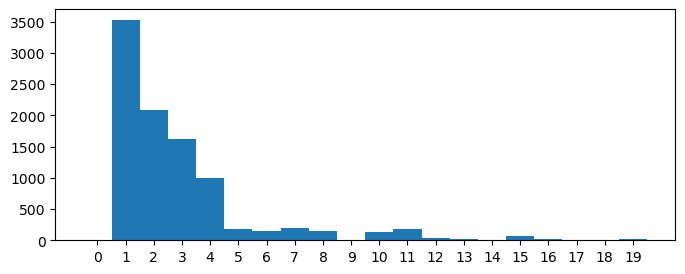

In [ ]:
unique_key = [
    'yyyy-mm-ddThh:mm:ss.sss', 
    'Longitude [degrees_east]', 
    'Latitude [degrees_north]', 
    'DEPTH [m]', 
    'BODC Bottle Number:INTEGER'
    ]

def count_non_nan(group):
    return group[cols_measurements].notna().sum(axis=1).iloc[0]


non_nan_counts = df_test.groupby(unique_key).apply(count_non_nan)

from matplotlib import pyplot as plt
# Calculate the range for bins
max_count = int(non_nan_counts.max())
bins = np.arange(0, max_count + 2) - 0.5  # +2 to include the max value, -0.5 for bin edges

# Create the histogram
plt.figure(figsize=(8, 3))
plt.hist(non_nan_counts.values, bins=bins)

plt.xticks(range(0, max_count + 1));

In [ ]:
# If we use the unique key as is, how many different measurements do we get per unique sample?

df_test.groupby(unique_key).size().sort_values(ascending=False)

In [ ]:
df_test.columns

Index(['yyyy-mm-ddThh:mm:ss.sss', 'Longitude [degrees_east]',
       'Latitude [degrees_north]', 'Bot. Depth [m]', 'DEPTH [m]',
       'BODC Bottle Number:INTEGER', 'TRITIUM_D_CONC_BOTTLE [TU]',
       'Cs_137_D_CONC_BOTTLE [uBq/kg]', 'I_129_D_CONC_BOTTLE [atoms/kg]',
       'Np_237_D_CONC_BOTTLE [uBq/kg]', 'Pu_239_D_CONC_BOTTLE [uBq/kg]',
       'Pu_239_Pu_240_D_CONC_BOTTLE [uBq/kg]', 'Pu_240_D_CONC_BOTTLE [uBq/kg]',
       'U_236_D_CONC_BOTTLE [atoms/kg]', 'U_236_T_CONC_BOTTLE [atoms/kg]',
       'U_236_D_CONC_FISH [atoms/kg]', 'Cs_137_D_CONC_UWAY [uBq/kg]',
       'Pu_239_Pu_240_D_CONC_UWAY [uBq/kg]', 'Pa_231_D_CONC_BOTTLE [uBq/kg]',
       'Pb_210_D_CONC_BOTTLE [mBq/kg]', 'Po_210_D_CONC_BOTTLE [mBq/kg]',
       'Ra_224_D_CONC_BOTTLE [mBq/kg]', 'Ra_226_D_CONC_BOTTLE [mBq/kg]',
       'Ra_228_T_CONC_BOTTLE [mBq/kg]', 'Ra_228_D_CONC_BOTTLE [mBq/kg]',
       'Th_230_T_CONC_BOTTLE [uBq/kg]', 'Th_230_D_CONC_BOTTLE [uBq/kg]',
       'Th_232_T_CONC_BOTTLE [pmol/kg]', 'Th_232_D_CONC_BOTTLE 

In [ ]:
unique_key = [
    'yyyy-mm-ddThh:mm:ss.sss', 'Longitude [degrees_east]', 
    'Latitude [degrees_north]', 'DEPTH [m]', 'BODC Bottle Number:INTEGER']

df_test[df_test[unique_key].duplicated(keep=False)].sort_values(by=unique_key)

,yyyy-mm-ddThh:mm:ss.sss,Longitude [degrees_east],Latitude [degrees_north],Bot. Depth [m],DEPTH [m],BODC Bottle Number:INTEGER,TRITIUM_D_CONC_BOTTLE [TU],Cs_137_D_CONC_BOTTLE [uBq/kg],I_129_D_CONC_BOTTLE [atoms/kg],Np_237_D_CONC_BOTTLE [uBq/kg],...,Th_230_TP_CONC_PUMP [uBq/kg],Th_230_SPT_CONC_PUMP [uBq/kg],Th_230_LPT_CONC_PUMP [uBq/kg],Th_232_TP_CONC_PUMP [pmol/kg],Th_232_SPT_CONC_PUMP [pmol/kg],Th_232_LPT_CONC_PUMP [pmol/kg],Th_234_SPT_CONC_PUMP [mBq/kg],Th_234_LPT_CONC_PUMP [mBq/kg],Po_210_TP_CONC_UWAY [mBq/kg],Pb_210_TP_CONC_UWAY [mBq/kg]


### Reshape: wide to long

So that we can extract information such as sample methodology, filtering status, units included in Geotraces nuclides name.

In [ ]:
#| exports
class WideToLongCB(Callback):
    """
    Get Geotraces nuclide names as values not column names 
    to extract contained information (unit, sampling method, ...).
    """
    def __init__(self, common_coi, nuclides_pattern, 
                 var_name='nuclide', value_name='value'): 
        fc.store_attr()
        
    def __call__(self, tfm):
        nuc_of_interest = [c for c in tfm.df.columns if 
                           any(re.match(pattern, c) for pattern in self.nuclides_pattern)]
        tfm.df = pd.melt(tfm.df, id_vars=self.common_coi, value_vars=nuc_of_interest, 
                          var_name=self.var_name, value_name=self.value_name)
        tfm.df.dropna(subset='value', inplace=True)

In [ ]:
#| eval: false
tfm = Transformer(df, cbs=[
    SelectColsOfInterestCB(common_coi, nuclides_pattern),
    WideToLongCB(common_coi, nuclides_pattern)
])
df_test = tfm()
df_test.shape

(26745, 7)

### Extract

#### Unit

In [ ]:
#| exports
class ExtractUnitCB(Callback):
    """
    Extract units from nuclide names.
    """
    def __init__(self, var_name='nuclide'): 
        fc.store_attr()
        self.unit_col_name = cdl_cfg()['vars']['suffixes']['unit']['name']

    def extract_unit(self, s):
        match = re.search(r'\[(.*?)\]', s)
        return match.group(1) if match else None
        
    def __call__(self, tfm):
        tfm.df[self.unit_col_name] = tfm.df[self.var_name].apply(self.extract_unit)

In [ ]:
#| eval: false
tfm = Transformer(df, cbs=[
    SelectColsOfInterestCB(common_coi, nuclides_pattern),
    WideToLongCB(common_coi, nuclides_pattern),
    ExtractUnitCB()
])

df_test = tfm()
df_test.head()

,yyyy-mm-ddThh:mm:ss.sss,Longitude [degrees_east],Latitude [degrees_north],Bot. Depth [m],DEPTH [m],nuclide,value,_unit
9223,2010-10-17T00:13:29,350.33792,38.3271,2827.0,17.8,TRITIUM_D_CONC_BOTTLE [TU],0.733,TU
9231,2010-10-17T00:13:29,350.33792,38.3271,2827.0,34.7,TRITIUM_D_CONC_BOTTLE [TU],0.696,TU
9237,2010-10-17T00:13:29,350.33792,38.3271,2827.0,67.5,TRITIUM_D_CONC_BOTTLE [TU],0.718,TU
9244,2010-10-17T00:13:29,350.33792,38.3271,2827.0,91.9,TRITIUM_D_CONC_BOTTLE [TU],0.709,TU
9256,2010-10-17T00:13:29,350.33792,38.3271,2827.0,136.6,TRITIUM_D_CONC_BOTTLE [TU],0.692,TU


#### Filtering status

In [ ]:
#| exports
phase = {
    'D': {'filt': 1, 'group': 'seawater'},
    'T': {'filt': 2, 'group': 'seawater'},
    'TP': {'filt': 1, 'group': 'suspended-matter'}, 
    'LPT': {'filt': 1, 'group': 'suspended-matter'},
    'SPT': {'filt': 1, 'group': 'suspended-matter'}}

In [ ]:
#| exports
class ExtractFilteringStatusCB(Callback):
    "Extract filtering status from nuclide names."
    def __init__(self, phase, var_name='nuclide'): 
        fc.store_attr()
        self.filt_col_name = cdl_cfg()['vars']['suffixes']['filtered']['name']

    def extract_filt_status(self, s):
        matched_string = self.match(s)
        return self.phase[matched_string.group(1)]['filt'] if matched_string else None

    def match(self, s):
        return re.search(r'_(' + '|'.join(self.phase.keys()) + ')_', s)
        
    def extract_group(self, s):
        matched_string = self.match(s)
        return self.phase[matched_string.group(1)]['group'] if matched_string else None
        
    def __call__(self, tfm):
        tfm.df[self.filt_col_name] = tfm.df[self.var_name].apply(self.extract_filt_status)
        tfm.df['group'] = tfm.df[self.var_name].apply(self.extract_group)

In [ ]:
#|eval: false
tfm = Transformer(df, cbs=[
    SelectColsOfInterestCB(common_coi, nuclides_pattern),
    WideToLongCB(common_coi, nuclides_pattern),
    ExtractUnitCB(),
    ExtractFilteringStatusCB(phase)
])

df_test = tfm()
df_test.head()

,yyyy-mm-ddThh:mm:ss.sss,Longitude [degrees_east],Latitude [degrees_north],Bot. Depth [m],DEPTH [m],nuclide,value,_unit,_filt,group
9223,2010-10-17T00:13:29,350.33792,38.3271,2827.0,17.8,TRITIUM_D_CONC_BOTTLE [TU],0.733,TU,1,seawater
9231,2010-10-17T00:13:29,350.33792,38.3271,2827.0,34.7,TRITIUM_D_CONC_BOTTLE [TU],0.696,TU,1,seawater
9237,2010-10-17T00:13:29,350.33792,38.3271,2827.0,67.5,TRITIUM_D_CONC_BOTTLE [TU],0.718,TU,1,seawater
9244,2010-10-17T00:13:29,350.33792,38.3271,2827.0,91.9,TRITIUM_D_CONC_BOTTLE [TU],0.709,TU,1,seawater
9256,2010-10-17T00:13:29,350.33792,38.3271,2827.0,136.6,TRITIUM_D_CONC_BOTTLE [TU],0.692,TU,1,seawater


#### Sampling method

In [ ]:
#| exports
# To be validated
smp_method = {
    'BOTTLE': 1,
    'FISH': 18,
    'PUMP': 14,
    'UWAY': 24}

In [ ]:
#| exports
class ExtractSamplingMethodCB(Callback):
    "Extract sampling method from nuclide names."
    def __init__(self, smp_method, var_name='nuclide'): 
        fc.store_attr()
        self.smp_method_col_name = cdl_cfg()['vars']['suffixes']['sampling_method']['name']

    def extract_smp_method(self, s):
        match = re.search(r'_(' + '|'.join(self.smp_method.keys()) + ') ', s)
        return self.smp_method[match.group(1)] if match else None
        
    def __call__(self, tfm):
        tfm.df[self.smp_method_col_name] = tfm.df[self.var_name].apply(self.extract_smp_method)

In [ ]:
#| eval: false
tfm = Transformer(df, cbs=[
    SelectColsOfInterestCB(common_coi, nuclides_pattern),
    WideToLongCB(common_coi, nuclides_pattern),
    ExtractUnitCB(),
    ExtractFilteringStatusCB(phase),
    ExtractSamplingMethodCB(smp_method)
])

df_test = tfm()
df_test.head()

,yyyy-mm-ddThh:mm:ss.sss,Longitude [degrees_east],Latitude [degrees_north],Bot. Depth [m],DEPTH [m],nuclide,value,_unit,_filt,group,_sampmet
9223,2010-10-17T00:13:29,350.33792,38.3271,2827.0,17.8,TRITIUM_D_CONC_BOTTLE [TU],0.733,TU,1,seawater,1
9231,2010-10-17T00:13:29,350.33792,38.3271,2827.0,34.7,TRITIUM_D_CONC_BOTTLE [TU],0.696,TU,1,seawater,1
9237,2010-10-17T00:13:29,350.33792,38.3271,2827.0,67.5,TRITIUM_D_CONC_BOTTLE [TU],0.718,TU,1,seawater,1
9244,2010-10-17T00:13:29,350.33792,38.3271,2827.0,91.9,TRITIUM_D_CONC_BOTTLE [TU],0.709,TU,1,seawater,1
9256,2010-10-17T00:13:29,350.33792,38.3271,2827.0,136.6,TRITIUM_D_CONC_BOTTLE [TU],0.692,TU,1,seawater,1


### Remap to MARIS nuclide names 

In [ ]:
#| exports
nuclides_name = {'TRITIUM': 'h3', 'Pu_239_Pu_240': 'pu239_240_tot'}

In [ ]:
#| exports
class RenameNuclideCB(Callback):
    "Remap nuclides name to MARIS standard."
    def __init__(self, nuclides_name, var_name='nuclide'): 
        fc.store_attr()
        self.patterns = ['_D', '_T', '_TP', '_LPT', '_SPT']

    def extract_nuclide_name(self, s):
        match = re.search(r'(.*?)(' + '|'.join(self.patterns) + ')', s)
        return match.group(1) if match else None

    def standardize_name(self, s):
        s = self.extract_nuclide_name(s)
        return self.nuclides_name[s] if s in self.nuclides_name else s.lower().replace('_', '')
        
    def __call__(self, tfm):
        tfm.df[self.var_name] = tfm.df[self.var_name].apply(self.standardize_name)

In [ ]:
#|eval: false
tfm = Transformer(df, cbs=[
    SelectColsOfInterestCB(common_coi, nuclides_pattern),
    WideToLongCB(common_coi, nuclides_pattern),
    ExtractUnitCB(),
    ExtractFilteringStatusCB(phase),
    ExtractSamplingMethodCB(smp_method),
    RenameNuclideCB(nuclides_name)
])

df_test = tfm()
df_test.head()

,yyyy-mm-ddThh:mm:ss.sss,Longitude [degrees_east],Latitude [degrees_north],Bot. Depth [m],DEPTH [m],nuclide,value,_unit,_filt,group,_sampmet
9223,2010-10-17T00:13:29,350.33792,38.3271,2827.0,17.8,h3,0.733,TU,1,seawater,1
9231,2010-10-17T00:13:29,350.33792,38.3271,2827.0,34.7,h3,0.696,TU,1,seawater,1
9237,2010-10-17T00:13:29,350.33792,38.3271,2827.0,67.5,h3,0.718,TU,1,seawater,1
9244,2010-10-17T00:13:29,350.33792,38.3271,2827.0,91.9,h3,0.709,TU,1,seawater,1
9256,2010-10-17T00:13:29,350.33792,38.3271,2827.0,136.6,h3,0.692,TU,1,seawater,1


In [ ]:
#| eval: false
df_test.nuclide.unique()

array(['h3', 'cs137', 'i129', 'np237', 'pu239', 'pu239_240_tot', 'pu240',
       'u236', 'pa231', 'pb210', 'po210', 'ra224', 'ra226', 'ra228',
       'th230', 'th232', 'th234', 'ac227', 'be7', 'ra223', 'th228'],
      dtype=object)

### Standardize unit

In [ ]:
#| exports
units_lut = {
    'TU': {'id': 7, 'factor': 1},
    'uBq/kg': {'id': 3, 'factor': 1e-6},
    'atoms/kg': {'id': 9, 'factor': 1},
    'mBq/kg': {'id': 3, 'factor': 1e-3}}

In [ ]:
#| exports
class StandardizeUnitCB(Callback):
    "Remap unit to MARIS standard ones and apply conversion where needed."
    def __init__(self, units_lut, var_name='value'): 
        fc.store_attr()
        self.unit_col_name = cdl_cfg()['vars']['suffixes']['unit']['name']
        
    def __call__(self, tfm):
        # Convert/rescale values
        tfm.df[self.var_name] *= tfm.df[self.unit_col_name].map(
            {k: v['factor'] for k, v in self.units_lut.items()})
        
        # Match MARIS unit id
        tfm.df[self.unit_col_name] = tfm.df[self.unit_col_name].map(
            {k: v['id'] for k, v in self.units_lut.items()})

In [ ]:
#|eval: false
tfm = Transformer(df, cbs=[
    SelectColsOfInterestCB(common_coi, nuclides_pattern),
    WideToLongCB(common_coi, nuclides_pattern),
    ExtractUnitCB(),
    ExtractFilteringStatusCB(phase),
    ExtractSamplingMethodCB(smp_method),
    RenameNuclideCB(nuclides_name),
    StandardizeUnitCB(units_lut)
])

df_test = tfm()
print(df_test.head())
print(df_test.columns)

     yyyy-mm-ddThh:mm:ss.sss  Longitude [degrees_east]  \
9223     2010-10-17T00:13:29                 350.33792   
9231     2010-10-17T00:13:29                 350.33792   
9237     2010-10-17T00:13:29                 350.33792   
9244     2010-10-17T00:13:29                 350.33792   
9256     2010-10-17T00:13:29                 350.33792   

      Latitude [degrees_north]  Bot. Depth [m]  DEPTH [m] nuclide  value  \
9223                   38.3271          2827.0       17.8      h3  0.733   
9231                   38.3271          2827.0       34.7      h3  0.696   
9237                   38.3271          2827.0       67.5      h3  0.718   
9244                   38.3271          2827.0       91.9      h3  0.709   
9256                   38.3271          2827.0      136.6      h3  0.692   

      _unit  _filt     group  _sampmet  
9223    7.0      1  seawater         1  
9231    7.0      1  seawater         1  
9237    7.0      1  seawater         1  
9244    7.0      1  seawater  

### Rename common columns

In [ ]:
#| exports
def renaming_rules():
    "Define column names renaming rules."
    vars = cdl_cfg()['vars']
    return {
        'yyyy-mm-ddThh:mm:ss.sss': vars['defaults']['time']['name'],
        'Longitude [degrees_east]': vars['defaults']['lon']['name'],
        'Latitude [degrees_north]': vars['defaults']['lat']['name'],
        'DEPTH [m]': vars['defaults']['smp_depth']['name'],
        'Bot. Depth [m]': vars['defaults']['tot_depth']['name']
    }

In [ ]:
#| exports
class RenameColumnCB(Callback):
    "Renaming variables to MARIS standard names."
    def __init__(self, renaming_rules=renaming_rules): fc.store_attr()
    def __call__(self, tfm):
        lut = self.renaming_rules()
        new_col_names = [lut[name] if name in lut else name for name in tfm.df.columns]
        tfm.df.columns = new_col_names

In [ ]:
#|eval: false
tfm = Transformer(df, cbs=[
    SelectColsOfInterestCB(common_coi, nuclides_pattern),
    WideToLongCB(common_coi, nuclides_pattern),
    ExtractUnitCB(),
    ExtractFilteringStatusCB(phase),
    ExtractSamplingMethodCB(smp_method),
    RenameNuclideCB(nuclides_name),
    StandardizeUnitCB(units_lut),
    RenameColumnCB(renaming_rules)
])

df_test = tfm()
df_test.head()

,time,lon,lat,tot_depth,smp_depth,nuclide,value,_unit,_filt,group,_sampmet
9223,2010-10-17T00:13:29,350.33792,38.3271,2827.0,17.8,h3,0.733,7.0,1,seawater,1
9231,2010-10-17T00:13:29,350.33792,38.3271,2827.0,34.7,h3,0.696,7.0,1,seawater,1
9237,2010-10-17T00:13:29,350.33792,38.3271,2827.0,67.5,h3,0.718,7.0,1,seawater,1
9244,2010-10-17T00:13:29,350.33792,38.3271,2827.0,91.9,h3,0.709,7.0,1,seawater,1
9256,2010-10-17T00:13:29,350.33792,38.3271,2827.0,136.6,h3,0.692,7.0,1,seawater,1


### Unshift longitudes

In [ ]:
#| exports
class UnshiftLongitudeCB(Callback):
    "Longitudes are coded between 0 and 360 in Geotraces. We rescale it between -180 and 180 instead."
    def __init__(self): 
        self.lon_col_name = cdl_cfg()['vars']['defaults']['lon']['name']
    
    def __call__(self, tfm):
        tfm.df[self.lon_col_name] = tfm.df[self.lon_col_name] - 180

In [ ]:
#| eval: false
tfm = Transformer(df, cbs=[
    SelectColsOfInterestCB(common_coi, nuclides_pattern),
    WideToLongCB(common_coi, nuclides_pattern),
    ExtractUnitCB(),
    ExtractFilteringStatusCB(phase),
    ExtractSamplingMethodCB(smp_method),
    RenameNuclideCB(nuclides_name),
    StandardizeUnitCB(units_lut),
    RenameColumnCB(renaming_rules),
    UnshiftLongitudeCB()
])

df_test = tfm()
df_test.head()

,time,lon,lat,tot_depth,smp_depth,nuclide,value,_unit,_filt,group,_sampmet
9223,2010-10-17T00:13:29,170.33792,38.3271,2827.0,17.8,h3,0.733,7.0,1,seawater,1
9231,2010-10-17T00:13:29,170.33792,38.3271,2827.0,34.7,h3,0.696,7.0,1,seawater,1
9237,2010-10-17T00:13:29,170.33792,38.3271,2827.0,67.5,h3,0.718,7.0,1,seawater,1
9244,2010-10-17T00:13:29,170.33792,38.3271,2827.0,91.9,h3,0.709,7.0,1,seawater,1
9256,2010-10-17T00:13:29,170.33792,38.3271,2827.0,136.6,h3,0.692,7.0,1,seawater,1


### Dispatch to groups

In [ ]:
# TO BE DONE

In [ ]:
#| export
class DispatchToGroupCB(Callback):
    "Convert to a dictionary of dataframe with sample type (seawater,...) as keys."
    def __init__(self, group_name='group'): 
        fc.store_attr()
        
    def __call__(self, tfm):
        tfm.dfs = dict(tuple(tfm.df.groupby(self.group_name)))
        for key in tfm.dfs:
            tfm.dfs[key] = tfm.dfs[key].drop(self.group_name, axis=1)

In [ ]:
#|eval: false
df = pd.read_csv(fname_in)

tfm = Transformer(df, cbs=[
    SelectColsOfInterestCB(common_coi, nuclides_pattern),
    WideToLongCB(common_coi, nuclides_pattern),
    ExtractUnitCB(),
    ExtractFilteringStatusCB(phase),
    ExtractSamplingMethodCB(smp_method),
    RenameNuclideCB(nuclides_name),
    StandardizeUnitCB(units_lut),
    RenameColumnCB(renaming_rules),
    UnshiftLongitudeCB(),
    DispatchToGroupCB()
])

dfs_test = tfm()
print(f'dfs_test keys: {dfs_test.keys()}')
print(dfs_test['seawater'].head())

dfs_test keys: dict_keys(['seawater', 'suspended-matter'])
                     time        lon      lat  tot_depth  smp_depth nuclide  \
9223  2010-10-17T00:13:29  170.33792  38.3271     2827.0       17.8      h3   
9231  2010-10-17T00:13:29  170.33792  38.3271     2827.0       34.7      h3   
9237  2010-10-17T00:13:29  170.33792  38.3271     2827.0       67.5      h3   
9244  2010-10-17T00:13:29  170.33792  38.3271     2827.0       91.9      h3   
9256  2010-10-17T00:13:29  170.33792  38.3271     2827.0      136.6      h3   

      value  _unit  _filt  _sampmet  
9223  0.733    7.0      1         1  
9231  0.696    7.0      1         1  
9237  0.718    7.0      1         1  
9244  0.709    7.0      1         1  
9256  0.692    7.0      1         1  


In [ ]:
dfs_test['seawater'].columns

Index(['time', 'lon', 'lat', 'tot_depth', 'smp_depth', 'nuclide', 'value',
       '_unit', '_filt', '_sampmet'],
      dtype='object')

In [ ]:
dfs_test['seawater'].shape

(19139, 10)

In [ ]:
dfs_test['seawater'][['lon', 'time', 'tot_depth', 'smp_depth', 'lat']].duplicated().sum()



10733

### Rehape: long to wide

In [ ]:
#| export
# class ReshapeLongToWide(Callback):
#     "Convert data from long to wide with renamed columns."
#     def __init__(self, columns='nuclide', values=['value']):
#         fc.store_attr()
#         # Retrieve all possible derived vars (e.g 'unc', 'dl', ...) from configs
#         self.derived_cols = [value['name'] for value in cdl_cfg()['vars']['suffixes'].values()]
    
#     def renamed_cols(self, cols):
#         "Flatten columns name"
#         return [inner if outer == "value" else f'{inner}{outer}'
#                 if inner else outer
#                 for outer, inner in cols]

#     def pivot(self, df):
#         # Among all possible 'derived cols' select the ones present in df
#         derived_coi = [col for col in self.derived_cols if col in df.columns]
        
#         df.reset_index(names='sample', inplace=True)
        
#         idx = list(set(df.columns) - set([self.columns] + derived_coi + self.values))
#         return df.pivot_table(index=idx,
#                               columns=self.columns,
#                               values=self.values + derived_coi,
#                               fill_value=np.nan,
#                               aggfunc=lambda x: x
#                               ).reset_index()

#     def __call__(self, tfm):
#         for k in tfm.dfs.keys():
#             tfm.dfs[k] = self.pivot(tfm.dfs[k])
#             tfm.dfs[k].columns = self.renamed_cols(tfm.dfs[k].columns)

In [ ]:
#|eval: false
tfm = Transformer(df, cbs=[
    SelectColsOfInterestCB(common_coi, nuclides_pattern),
    WideToLongCB(common_coi, nuclides_pattern),
    ExtractUnitCB(),
    ExtractFilteringStatusCB(phase),
    ExtractSamplingMethodCB(smp_method),
    RenameNuclideCB(nuclides_name),
    StandardizeUnitCB(units_lut),
    RenameColumnCB(renaming_rules),
    UnshiftLongitudeCB(),
    DispatchToGroupCB(),
    ReshapeLongToWide()
])

dfs_test = tfm()
print('shape: ', dfs_test['seawater'].shape)
print('columns: ', dfs_test['seawater'] .columns)
dfs_test['seawater'].head()

shape:  (8406, 89)
columns:  Index(['time', 'lat', 'tot_depth', 'smp_depth', 'lon', 'ac227_filt',
       'be7_filt', 'cs137_filt', 'h3_filt', 'i129_filt', 'np237_filt',
       'pa231_filt', 'pb210_filt', 'po210_filt', 'pu239_filt',
       'pu239_240_tot_filt', 'pu240_filt', 'ra223_filt', 'ra224_filt',
       'ra226_filt', 'ra228_filt', 'th228_filt', 'th230_filt', 'th232_filt',
       'th234_filt', 'u236_filt', 'ac227_sampmet', 'be7_sampmet',
       'cs137_sampmet', 'h3_sampmet', 'i129_sampmet', 'np237_sampmet',
       'pa231_sampmet', 'pb210_sampmet', 'po210_sampmet', 'pu239_sampmet',
       'pu239_240_tot_sampmet', 'pu240_sampmet', 'ra223_sampmet',
       'ra224_sampmet', 'ra226_sampmet', 'ra228_sampmet', 'th228_sampmet',
       'th230_sampmet', 'th232_sampmet', 'th234_sampmet', 'u236_sampmet',
       'ac227_unit', 'be7_unit', 'cs137_unit', 'h3_unit', 'i129_unit',
       'np237_unit', 'pa231_unit', 'pb210_unit', 'po210_unit', 'pu239_unit',
       'pu239_240_tot_unit', 'pu240_unit', 'r

,time,lat,tot_depth,smp_depth,lon,ac227_filt,be7_filt,cs137_filt,h3_filt,i129_filt,...,pu240,ra223,ra224,ra226,ra228,th228,th230,th232,th234,u236
org_index,,,,,,,,,,,,,,,,,,,,,
0,2007-07-30T10:37:19,75.0005,181.0,7.0,-145.9999,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.028751,NaN
1,2007-07-30T10:37:19,75.0005,181.0,25.7,-145.9999,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.034914,NaN
2,2007-07-30T10:37:19,75.0005,181.0,49.5,-145.9999,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.037409,NaN
3,2007-07-30T10:37:19,75.0005,181.0,74.6,-145.9999,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.033527,NaN
4,2007-07-30T10:37:19,75.0005,181.0,100.2,-145.9999,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.034267,NaN


In [ ]:
dfs_test['seawater'][['lon', 'time', 'lat', 'smp_depth', 'tot_depth']].duplicated().sum()

0

In [ ]:
result =dfs_test['seawater'].drop(['lon', 'time', 'lat', 'smp_depth', 'tot_depth'], axis=1)

In [ ]:
dfs_test['seawater'].shape

(8406, 89)

In [ ]:
result[(~(result.isna())).sum(axis=1) > 20]

,ac227_filt,be7_filt,cs137_filt,h3_filt,i129_filt,np237_filt,pa231_filt,pb210_filt,po210_filt,pu239_filt,...,pu240,ra223,ra224,ra226,ra228,th228,th230,th232,th234,u236
org_index,,,,,,,,,,,,,,,,,,,,,
21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,...,NaN,NaN,0.000091,0.00112,0.000327,NaN,NaN,NaN,0.030734,NaN
31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,...,NaN,NaN,0.000044,0.000888,0.000311,NaN,NaN,NaN,0.025989,NaN
64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,...,NaN,NaN,0.000208,0.001169,0.000262,NaN,NaN,NaN,0.037707,NaN
91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,...,NaN,NaN,0.00028,0.001167,0.00028,NaN,NaN,NaN,0.038946,NaN
99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,...,NaN,NaN,0.000166,0.001224,0.000259,NaN,NaN,NaN,0.033485,NaN
106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,...,NaN,NaN,0.000132,0.001208,0.000312,NaN,NaN,NaN,0.029319,NaN
116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,...,NaN,NaN,0.000107,0.001141,0.000262,NaN,NaN,NaN,0.027518,NaN
123,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN,...,NaN,NaN,0.00013,0.001148,0.000254,NaN,NaN,NaN,0.030561,NaN
135,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN,...,NaN,NaN,0.000159,0.001218,0.000402,NaN,NaN,NaN,0.032424,NaN


<Axes: >

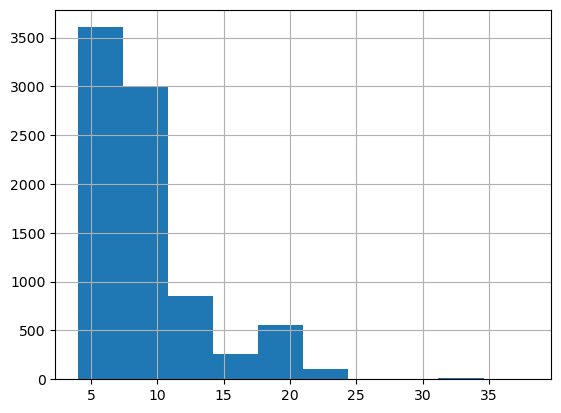

In [ ]:
(~(result.isna())).sum(axis=1).hist()

In [ ]:
~(result.isna().sum(axis=1) > 1)

org_index
0       False
1       False
2       False
3       False
4       False
        ...  
8401    False
8402    False
8403    False
8404    False
8405    False
Length: 8406, dtype: bool

In [ ]:

result.iloc[9223]


ac227_filt               NaN
be7_filt                 NaN
cs137_filt               NaN
h3_filt                  NaN
i129_filt                NaN
np237_filt               NaN
pa231_filt               NaN
pb210_filt               NaN
po210_filt               NaN
pu239_filt               NaN
pu239_240_tot_filt       NaN
pu240_filt               NaN
ra223_filt               NaN
ra224_filt               NaN
ra226_filt               NaN
ra228_filt               NaN
th228_filt               NaN
th230_filt               NaN
th232_filt               1.0
th234_filt               NaN
u236_filt                NaN
ac227_sampmet            NaN
be7_sampmet              NaN
cs137_sampmet            NaN
h3_sampmet               NaN
i129_sampmet             NaN
np237_sampmet            NaN
pa231_sampmet            NaN
pb210_sampmet            NaN
po210_sampmet            NaN
pu239_sampmet            NaN
pu239_240_tot_sampmet    NaN
pu240_sampmet            NaN
ra223_sampmet            NaN
ra224_sampmet 

### Parse time

In [ ]:
#| export
class ParseTimeCB(Callback):
    def __call__(self, tfm):
        for k in tfm.dfs.keys():
            tfm.dfs[k]['time'] = pd.to_datetime(tfm.dfs[k].time, format='ISO8601')

In [ ]:
#|eval: false
df = pd.read_csv(fname_in)

tfm = Transformer(df, cbs=[
    SelectColsOfInterestCB(common_coi, nuclides_pattern),
    WideToLongCB(common_coi, nuclides_pattern),
    ExtractUnitCB(),
    ExtractFilteringStatusCB(phase),
    ExtractSamplingMethodCB(smp_method),
    RenameNuclideCB(nuclides_name),
    StandardizeUnitCB(units_lut),
    RenameColumnCB(renaming_rules),
    UnshiftLongitudeCB(),
    DispatchToGroupCB(),
    ReshapeLongToWide(),
    ParseTimeCB()
])

print('time data type: ', tfm()['seawater'].time.dtype)

time data type:  datetime64[ns]


### Encode time (seconds since ...)

In [ ]:
#|eval: false
df = pd.read_csv(fname_in)

tfm = Transformer(df, cbs=[
    SelectColsOfInterestCB(common_coi, nuclides_pattern),
    WideToLongCB(common_coi, nuclides_pattern),
    ExtractUnitCB(),
    ExtractFilteringStatusCB(phase),
    ExtractSamplingMethodCB(smp_method),
    RenameNuclideCB(nuclides_name),
    StandardizeUnitCB(units_lut),
    RenameColumnCB(renaming_rules),
    UnshiftLongitudeCB(),
    DispatchToGroupCB(),
    ReshapeLongToWide(),
    ParseTimeCB(),
    EncodeTimeCB(cfg())
])

dfs_test = tfm()['seawater']
dfs_test.head()

,lat,lon,time,sample,tot_depth,smp_depth,ac227_filt,be7_filt,cs137_filt,h3_filt,...,pu239_240_tot,pu240,ra223,ra224,ra226,ra228,th228,th230,th234,u236
0,-70.5744,171.8772,1204725465,1306733,136.0,9.7,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-70.5744,171.8772,1204725465,1306747,136.0,135.6,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-70.5744,171.8772,1204725465,2150069,136.0,9.7,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000002,NaN,NaN
3,-70.5744,171.8772,1204725465,2150083,136.0,135.6,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000003,NaN,NaN
4,-70.5744,171.8772,1204725465,2360903,136.0,9.7,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Sanitize coordinates

In [ ]:
#|eval: false
df = pd.read_csv(fname_in)

tfm = Transformer(df, cbs=[
    SelectColsOfInterestCB(common_coi, nuclides_pattern),
    WideToLongCB(common_coi, nuclides_pattern),
    ExtractUnitCB(),
    ExtractFilteringStatusCB(phase),
    ExtractSamplingMethodCB(smp_method),
    RenameNuclideCB(nuclides_name),
    StandardizeUnitCB(units_lut),
    RenameColumnCB(renaming_rules),
    UnshiftLongitudeCB(),
    DispatchToGroupCB(),
    ReshapeLongToWide(),
    ParseTimeCB(),
    EncodeTimeCB(cfg()),
    SanitizeLonLatCB()
])
dfs_test = tfm()['seawater']
dfs_test.head()

,lat,lon,time,sample,tot_depth,smp_depth,ac227_filt,be7_filt,cs137_filt,h3_filt,...,pu239_240_tot,pu240,ra223,ra224,ra226,ra228,th228,th230,th234,u236
0,-70.5744,171.8772,1204725465,1306733,136.0,9.7,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-70.5744,171.8772,1204725465,1306747,136.0,135.6,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-70.5744,171.8772,1204725465,2150069,136.0,9.7,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000002,NaN,NaN
3,-70.5744,171.8772,1204725465,2150083,136.0,135.6,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000003,NaN,NaN
4,-70.5744,171.8772,1204725465,2360903,136.0,9.7,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## NetCDF encoder

### Example change logs

In [ ]:
#|eval: false
df = pd.read_csv(fname_in)

tfm = Transformer(df, cbs=[
    SelectColsOfInterestCB(common_coi, nuclides_pattern),
    WideToLongCB(common_coi, nuclides_pattern),
    ExtractUnitCB(),
    ExtractFilteringStatusCB(phase),
    ExtractSamplingMethodCB(smp_method),
    RenameNuclideCB(nuclides_name),
    StandardizeUnitCB(units_lut),
    RenameColumnCB(renaming_rules),
    UnshiftLongitudeCB(),
    DispatchToGroupCB(),
    ReshapeLongToWide(),
    ParseTimeCB(),
    EncodeTimeCB(cfg()),
    SanitizeLonLatCB()
])

tfm();

In [ ]:
#|eval: false
tfm.logs

['Select columns of interest.',
 '\n    Get Geotraces nuclide names as values not column names \n    to extract contained information (unit, sampling method, ...).\n    ',
 '\n    Extract units from nuclide names.\n    ',
 '\n    Extract filtering status from nuclide names.\n    ',
 '\n    Extract sampling method from nuclide names.\n    ',
 '\n    Remap nuclides name to MARIS standard.\n    ',
 '\n    Remap unit to MARIS standard ones and apply conversion where needed.\n    ',
 'Renaming variables to MARIS standard names.',
 'Longitudes are coded between 0 and 360 in Geotraces. We rescale it between -180 and 180 instead.',
 'Convert to a dictionary of dataframe with sample type (seawater,...) as keys.',
 'Convert data from long to wide with renamed columns.',
 'Encode time as `int` representing seconds since xxx',
 'Drop row when both longitude & latitude equal 0. Drop unrealistic longitude & latitude values. Convert longitude & latitude `,` separator to `.` separator.']

### Feed global attributes

In [ ]:
#| export
kw = ['oceanography', 'Earth Science > Oceans > Ocean Chemistry> Radionuclides',
      'Earth Science > Human Dimensions > Environmental Impacts > Nuclear Radiation Exposure',
      'Earth Science > Oceans > Ocean Chemistry > Ocean Tracers, Earth Science > Oceans > Marine Sediments',
      'Earth Science > Oceans > Ocean Chemistry, Earth Science > Oceans > Sea Ice > Isotopes',
      'Earth Science > Oceans > Water Quality > Ocean Contaminants',
      'Earth Science > Biological Classification > Animals/Vertebrates > Fish',
      'Earth Science > Biosphere > Ecosystems > Marine Ecosystems',
      'Earth Science > Biological Classification > Animals/Invertebrates > Mollusks',
      'Earth Science > Biological Classification > Animals/Invertebrates > Arthropods > Crustaceans',
      'Earth Science > Biological Classification > Plants > Macroalgae (Seaweeds)']

In [ ]:
#| export
def get_attrs(tfm, zotero_key, kw=kw):
    return GlobAttrsFeeder(tfm.dfs, cbs=[
        BboxCB(),
        DepthRangeCB(),
        TimeRangeCB(cfg()),
        ZoteroCB(zotero_key, cfg=cfg()),
        KeyValuePairCB('keywords', ', '.join(kw)),
        KeyValuePairCB('publisher_postprocess_logs', ', '.join(tfm.logs))
        ])()

In [ ]:
#|eval: false
zotero_metadata = get_attrs(tfm, zotero_key='97UIMEXN', kw=kw)
print('Keys: ', zotero_metadata.keys())
print('Title: ', zotero_metadata['title'])

Keys:  dict_keys(['geospatial_lat_min', 'geospatial_lat_max', 'geospatial_lon_min', 'geospatial_lon_max', 'geospatial_bounds', 'time_coverage_start', 'time_coverage_end', 'title', 'summary', 'creator_name', 'keywords', 'publisher_postprocess_logs'])
Title:  The GEOTRACES Intermediate Data Product 2017


In [ ]:
#| export
#def enums_xtra(tfm, vars):
#    "Retrieve a subset of the lengthy enum as 'species_t' for instance"
#    enums = Enums(lut_src_dir=lut_path(), cdl_enums=cdl_cfg()['enums'])
#    xtras = {}
#    for var in vars:
#        unique_vals = tfm.unique(var)
#        if unique_vals.any():
#            xtras[f'{var}_t'] = enums.filter(f'{var}_t', unique_vals)
#    return xtras

### Encoding

In [ ]:
#| export
def encode(fname_in, fname_out, nc_tpl_path, **kwargs):
    df = pd.read_csv(fname_in)
    tfm = Transformer(df, cbs=[
        SelectColsOfInterestCB(common_coi, nuclides_pattern),
        WideToLongCB(common_coi, nuclides_pattern),
        ExtractUnitCB(),
        ExtractFilteringStatusCB(phase),
        ExtractSamplingMethodCB(smp_method),
        RenameNuclideCB(nuclides_name),
        StandardizeUnitCB(units_lut),
        RenameColumnCB(renaming_rules),
        UnshiftLongitudeCB(),
        DispatchToGroupCB(),
        ReshapeLongToWide(),
        ParseTimeCB(),
        EncodeTimeCB(cfg()),
        SanitizeLonLatCB()
    ])
    tfm()
    encoder = NetCDFEncoder(tfm.dfs, 
                            src_fname=nc_tpl_path,
                            dest_fname=fname_out, 
                            global_attrs=get_attrs(tfm, zotero_key='97UIMEXN', kw=kw),
                            verbose=kwargs.get('verbose', False),
                            #enums_xtra=enums_xtra(tfm, vars=['species', 'body_part'])
                           )
    encoder.encode()

In [ ]:
#|eval: false
encode(fname_in, fname_out, nc_tpl_path(), verbose=False)